In [24]:
import pandas as pd
import numpy as np
import os
import pickle
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('seaborn-notebook')

%matplotlib inline

pd.set_option('display.max_columns', 20)

## Data Sources
There are two similar yet slightly different sources for this data. The 2000 data comes from the Decennial United States Census whereas the 2009-2016 data comes from American Community Survey 5-year estimates. Both data sources contain roughly the same features, format, and geographic contraints (census tracts). 

In [25]:
#system agnostic data path
raw_data_dir = os.path.join(os.getcwd(), '..', 'data', 'raw')
#empty dict to hold all the variables, this will come in handy later
empty_vars = {'income': '', 'education': '', 'race': '',
              'rent': '', 'value': '', 'unemployment': ''}
#these are the data variable names for the decennial census
dec_data_vars = {'P052': 'income', 'QTP20': 'education', 'P007': 'race',
                 'H062': 'rent', 'H084': 'value', 'QTP24': 'unemployment'}
#these are the data variable names for the ACS 5-year estimates
acs_data_vars = {'B19001': 'income', 'S1501': 'education', 'B02001': 'race',
                 'B25063': 'rent', 'B25075': 'value', 'S2301': 'unemployment'}
#this will hold all the different file names to make reading data easier
data_dict = {
    '2000': empty_vars.copy(),
    '2009': empty_vars.copy(),
    '2010': empty_vars.copy(),
    '2011': empty_vars.copy(),
    '2012': empty_vars.copy(),
    '2013': empty_vars.copy(),
    '2014': empty_vars.copy(),
    '2015': empty_vars.copy(),
    '2016': empty_vars.copy()
}
#loop through raw data files (csv only) and assign each one to proper key
for fil in os.listdir(raw_data_dir):
    if fil.endswith('.csv'):
        fil_spl = fil.split('_')
        if fil_spl[3] in acs_data_vars.keys():
            data_dict['20'+fil_spl[1]][acs_data_vars[fil_spl[3]]] = os.path.join(raw_data_dir, fil)
        elif fil_spl[3] in dec_data_vars.keys():
            data_dict['20'+fil_spl[1]][dec_data_vars[fil_spl[3]]] = os.path.join(raw_data_dir, fil)
        else:
            print('Unexpected file not processed: {}'.format(fil))

Unexpected file not processed: ACS_09_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_15_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_11_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_12_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_16_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_10_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_14_5YR_B11001_with_ann.csv
Unexpected file not processed: DEC_00_SF4_QTP10_with_ann.csv
Unexpected file not processed: ACS_13_5YR_B11001_with_ann.csv


## Relating 2000 and 2010 Census Tracts
One complication that arises while working with census data is that tracts change over time as population changes. Tracts generally encompass a population between 2,500 and 8,000 people and are the intended to be a rough equivalent of a neighborhood. As the population grows, shrinks, and moves, some census tracts are split into smaller tracts while others are merged to form a new tract. This is the case between the 2000-2009 data, which use the 2000 census tracts, vs the 2010-2016 data, which use the 2010 census tracts. 

Thankfully, the Census Bureau tracks this sort of change very carefully and presents the morphology of census tracts in a detailed relationship file.

In [26]:
geoid_2000 = pd.read_csv(data_dict['2000']['income'], skiprows=1)['Id2']
geoid_2010 = pd.read_csv(data_dict['2016']['income'], skiprows=1)['Id2']

removed = list(set(geoid_2000) - set(geoid_2010))
added = list(set(geoid_2010) - set(geoid_2000))

tract_relations = pd.read_csv(os.path.join(os.getcwd(), '..', 'shapefiles', 'census_tract_relation_file.csv'),
                              usecols=[1, 3, 12, 25, 26])
tract_relations = tract_relations[tract_relations['county00'].isin([21, 55, 209, 453, 491])]

need_to_change = tract_relations[tract_relations['geoid00'].isin(removed)]
need_to_change = need_to_change[need_to_change['geoid10'].isin(added)]
need_to_change = need_to_change[need_to_change['poppct00'] > 0]
need_to_change = need_to_change[need_to_change['poppct10'] > 1]

need_to_change.to_csv(os.path.join(os.getcwd(), '..', 'shapefiles', 'need_to_change.csv'))

merged = need_to_change[(need_to_change['poppct00'] > 95) & (need_to_change['poppct10'] < 100)]
split = need_to_change[need_to_change['poppct10'] > 95]

In [27]:
def fix_tracts(df):
    #the tract for austin-bergstrom airport is missing from 2000 and 2009
    #there's no population or housing units in the tract (geoid: 48453980000)
    #so it can be filled in with zeros
    df.loc[48453980000] = 0
    #merged
    for geoid in merged['geoid10']:
        df.loc[geoid] = df.loc[list(merged['geoid00'])].sum()
    df.drop(list(merged['geoid00']), inplace=True)
    #split
    for row in split.iterrows():
        df.loc[row[1]['geoid10']] = round(df.loc[row[1]['geoid00']] * row[1]['poppct00'] / 100, 0)
    df.drop(list(split['geoid00'].unique()), inplace=True)
    df.astype('int')
    
    return df

In [28]:
def read_income(year):
    if year == '2000':
        usecols = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
                   12, 13, 14, 15, 16, 17, 18, 19]
    else:
        usecols=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19,
                 21, 23, 25, 27, 29, 31, 33, 35]
    income = pd.read_csv(data_dict[year]['income'], skiprows=1, usecols=usecols)
    income.index = income.pop('Id2')
    income.index.name = 'geoid'
    income.columns = ['total', '<10k', '[10k-15k)', '[15k-20k)',
                      '[20k-25k)', '[25k-30k)', '[30k-35k)', '[35k-40k)', '[40k-45k)',
                      '[45k-50k)', '[50k-60k)', '[60k-75k)', '[75k-100k)', '[100k-125k)',
                      '[125k-150k)', '[150k-200k)', '>200k']
    if year in ['2000', '2009']:
        income = fix_tracts(income)
    
    return income

In [29]:
def read_education(year):
    if year == '2000':
        usecols = [3, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53]
    elif year in ['2009', '2010', '2011', '2012', '2013']:
        usecols = [1, 33, 39, 45, 51, 57, 63, 69, 75]
    elif year == '2014':
        usecols = [1, 8, 9, 10, 11, 12, 13, 14, 15]
    else:
        usecols = [1, 13, 15, 17, 19, 21, 23, 25, 27]
    
    education = pd.read_csv(data_dict[year]['education'], skiprows=1, usecols=usecols, na_values=['-'])
    education.index = education.pop('Id2')
    education.index.name = 'geoid'
    
    if year == '2000':
        education.columns = ['total', '<5', '5-8', '9-12', 'high_school', 'some_college_1', 
                             'some_college_2', 'associate', 'bachelor', 'master', 
                             'professional', 'doctorate']
        education['<9'] = education.pop('<5') + education.pop('5-8')
        education['some_college'] = education.pop('some_college_1') + education.pop('some_college_2')
        education['graduate'] = education.pop('master') + education.pop('professional') \
                                + education.pop('doctorate')
        education = education[['total', '<9', '9-12', 'high_school', 'some_college',
                               'associate', 'bachelor', 'graduate']]
    
    elif year in ['2015', '2016']:
        education.columns = ['total', '<9', '9-12', 'high_school', 'some_college',
                             'associate', 'bachelor', 'graduate']
    
    else:
        education.columns = ['total', '<9', '9-12', 'high_school', 'some_college',
                             'associate', 'bachelor', 'graduate']
        education.fillna(0, inplace=True) #not actually missing - Austin-Bergrstrom Intl. Airport
        perc_cols = education.columns[1:]
        for c in perc_cols:
            education[c] = round(education[c] / 100 * education['total'], 0).astype('int')
        
    if year in ['2000', '2009']:
        education = fix_tracts(education)
        
    return education

In [30]:
def read_race(year):
    if year == '2000':
        usecols = [1, 3, 4]
    else:
        usecols = [1, 3, 5]
    race = pd.read_csv(data_dict[year]['race'], skiprows=1, usecols=usecols)
    race.index = race.pop('Id2')
    race.index.name = 'geoid'
    race.columns = ['total_population', 'white_alone']
    
    if year in ['2000', '2009']:
        race = fix_tracts(race)
        
    '''
    still need to convert to percent (here or next step?)
    '''
    
    return race

In [31]:
def read_families(year):
    if year == '2000':
        usecols = [3, 5, 7]
    else:
        usecols = [1, 3, 5]
    families = pd.read_csv(data_dict[year]['families'], skiprows=1, usecols=usecols)
    families.index = families.pop('Id2')
    families.index.name = 'geoid'
    families.columns = ['total_households', 'family_households']
    
    if year in ['2000', '2009']:
        families = fix_tracts(families)
        
    '''
    still need to convert to percent (here or next step?)
    '''
    
    return families

In [32]:
def read_rent(year):
    if year == '2000':
        usecols = [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                   17, 18, 19, 20, 21, 22, 23, 24, 25]
    elif year in ['2009', '2010', '2011', '2012', '2013', '2014']:
        usecols = [1, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 
                   27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47]
    else:
        usecols=[1, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 
                 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
                 51, 53]
    rent = pd.read_csv(data_dict[year]['rent'], skiprows=1, usecols=usecols)
    rent.index = rent.pop('Id2')
    rent.index.name = 'geoid'
    if year in ['2015', '2016']:
        rent['>2000'] = rent[rent.columns[21:25]].sum(axis=1)
        rent.drop(rent.columns[[21, 22, 23, 24]], axis=1, inplace=True)
    
    rent.columns = ['total', '<100', '[100-150)', '[150-200)', '[200-250)',
                    '[250-300)', '[300-350)', '[350-400)', '[400-450)', '[450-500)', '[500-550)',
                    '[550-600)', '[600-650)', '[650-700)', '[700-750)', '[750-800)', '[800-900)',
                    '[900-1000)', '[1000-1250)', '[1250-1500)', '[1500-2000)', '>2000']
    
    if year in ['2000', '2009']:
        rent = fix_tracts(rent)
    
    return rent

In [33]:
def read_value(year):
    if year == '2000':
        usecols = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                   16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
    elif year in ['2009', '2010', '2011', '2012', '2013', '2014']:
        usecols = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 
                   29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
    else:
        usecols = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 
                   29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55]
    
    value = pd.read_csv(data_dict[year]['value'], skiprows=1, usecols=usecols)
    value.index = value.pop('Id2')
    value.index.name = 'geoid'
    
    if year in ['2015', '2016']:
        value['>1M'] = value[value.columns[25:28]].sum(axis=1)
        value.drop(value.columns[[25, 26, 27]], axis=1, inplace=True)
    
    value.columns = ['total', '<10k', '[10k-15k)', '[15k-20k)', '[20k-25k)', 
                     '[25k-30k)', '[30k-35k)', '[35k-40k)', '[40k-50k)', '[50k-60k)', '[60k-70k)', 
                     '[70k-80k)', '[80k-90k)', '[90k-100k)', '[100k-125k)', '[125k-150k)', '[150k-175k)', 
                     '[175k-200k)', '[200k-250k)', '[250k-300k)', '[300k-400k)', '[400k-500k)', 
                     '[500k-750k)', '[750k-1M)', '>1M']
    
    if year in ['2000', '2009']:
        value = fix_tracts(value)
    
    return value

In [34]:
def read_unemployment(year):
    if year == '2000':
        usecols = [3, 5, 35]
    else:
        usecols = [1, 3, 9]
    unemployment = pd.read_csv(data_dict[year]['unemployment'], skiprows=1, usecols=usecols, na_values='-')
    unemployment.index = unemployment.pop('Id2')
    unemployment.index.name = 'geoid'
    unemployment.columns = ['total_in_labor_force', 'unemployed']
    if year != '2000':
        unemployment.fillna(0, inplace=True)
        unemployment['unemployed'] = round(unemployment['total_in_labor_force']\
                                           * unemployment['unemployed'] / 100, 0)
    
    if year in ['2000', '2009']:
        unemployment = fix_tracts(unemployment)
        
    return unemployment

In [35]:
all_data = {
    '2000': empty_vars.copy(),
    '2009': empty_vars.copy(),
    '2010': empty_vars.copy(),
    '2011': empty_vars.copy(),
    '2012': empty_vars.copy(),
    '2013': empty_vars.copy(),
    '2014': empty_vars.copy(),
    '2015': empty_vars.copy(),
    '2016': empty_vars.copy()
}

read_funs = [read_income, read_education, read_race,
             read_rent, read_value, read_unemployment]
read_vars = ['income', 'education', 'race', 
             'rent', 'value', 'unemployment']

for key in all_data.keys():
    for f, v in zip(read_funs, read_vars):
        all_data[key][v] = f(key)
        
pickle_all = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'all_data.pickle'), 'wb')
pickle.dump(all_data, pickle_all)

#All the data can now be read with the following two lines of code:
#pickle_in = open(os.path.join(os.getcwd(), '..', data', 'processed', 'all_data.pickle'), 'rb')
#data = pickle.load(pickle_in)

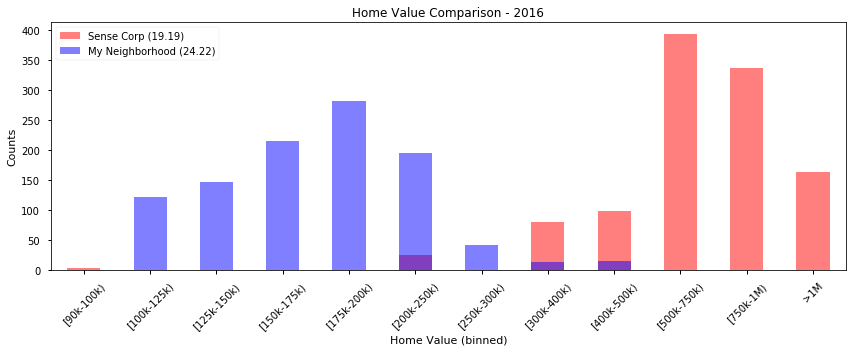

In [36]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))

all_data['2016']['value'].loc[48453001919, '[90k-100k)':].plot(kind='bar', 
                                                           ax=ax, 
                                                           color='red', 
                                                           alpha=0.5, 
                                                           label='Sense Corp (19.19)')
all_data['2016']['value'].loc[48453002422, '[90k-100k)':].plot(kind='bar', ax=ax, color='blue', 
                                                           alpha=0.5, label='My Neighborhood (24.22)')
_ = ax.legend(loc=2)
_ = plt.xticks(rotation=45)
_ = ax.set(xlabel='Home Value (binned)', ylabel='Counts',
           title='Home Value Comparison - 2016')
_ = fig.tight_layout()
_ = fig.savefig('../figures/home_value_comparison.png', dpi=500, transparent=True)

In [37]:
all_data['2016']['income'].head()

,total,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k
geoid,,,,,,,,,,,,,,,,,
48021950100,3074,132,49,182,181,84,148,203,128,84,292,388,413,276,285,192,37
48021950200,2596,196,224,89,214,280,125,101,92,84,167,283,261,239,104,76,61
48021950300,4726,204,187,67,274,129,104,244,302,356,403,371,543,766,278,359,139
48021950400,3521,187,116,229,200,213,257,229,129,162,370,392,462,305,150,93,27
48021950501,2176,89,26,195,174,87,102,143,131,57,150,342,204,225,76,127,48


## Transforming the data
Now we'll aggregate the binned data (rent, value, income, education) into indices, convert race and unemployment to percentages, as well as adjust each year for inflation.

In [38]:
pd.options.display.float_format = '{:,.3f}'.format
#make a copy of all_data for transforming data 
#need to use copy.deepcopy() here so that the dataframes inside the dictionary are
#copied as well - if you just you all_data.copy(), the dictionary will be copied but
#the dataframes will share memory and any modifications to dataframes will be applied 
#the dataframes in all_data as well
trans_data = copy.deepcopy(all_data)
#the scorer for monetary variables is the middle value of the bin with an assumed
#value for the uppermost bin
income_scorer = np.array([5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5,
                          55, 67.5, 87.5, 112.5, 137.5, 175, 300]) * 1000
rent_scorer = np.array([50, 125, 175, 225, 275, 325, 375, 425, 475, 525, 575,
                        625, 675, 725, 775, 850, 950, 1125, 1375, 1750, 2500])
value_scorer = np.array([5, 12.5, 17.5, 22.5, 27.5, 32.5, 27.5, 45, 55, 65, 75, 
                         85, 95, 112.5, 137.5, 162.5, 187.5, 225, 275, 350, 450, 
                         625, 875, 1500]) * 1000
#education gets a simple 1-8 score
education_scorer = np.arange(1, 8)

#to adjust the values to 2016 dollars, the index are adjusted by the 
#yearly average consumer price index 
inflation_correction = np.array([1.39422697, 1.11865482, 1.10084296, 1.06686838,
                                 1.04536021, 1.03039158, 1.01380104, 1.01263642, 
                                 1.00000000])

for i,year in enumerate(trans_data.keys()):
    for key in trans_data[year].keys():
        tmp = trans_data[year][key]
        #bust out the total population from the race df
        if key == 'race':
            population = tmp['total_population'].to_frame()
        #bust out total in labor force from the unemployment df
        if key == 'unemployment':
            tmp['employed'] = tmp['total_in_labor_force'] - tmp['unemployed']
        #convert columns to percentages of total and drop the total column
        tmp = tmp[tmp.columns[1:]].divide(tmp[tmp.columns[0]], axis=0).fillna(0)
        #calculate the index (single number to represent binned data)
        if len(tmp.columns) > 1:
            if key == 'income':
                tmp['income_index'] = tmp.dot(income_scorer) * inflation_correction[i]
            elif key == 'rent':
                tmp['rent_index'] = tmp.dot(rent_scorer) * inflation_correction[i]
            elif key == 'value':
                tmp['value_index'] = tmp.dot(value_scorer) * inflation_correction[i]
            elif key == 'education':
                tmp['education_index'] = tmp.dot(education_scorer)
                display(tmp.head())
        #put the new percentage column back into the dataframe
        trans_data[year][key] = tmp[tmp.columns[-1]].copy().to_frame()
    #concatenate the summary columns (1 for each dataframe) into a single dataframe
    trans_data[year] = pd.concat([trans_data[year][key] for key in trans_data[year].keys()], axis=1)
    #add a year column in the first position to be used later
    trans_data[year].insert(0, 'year', year)

,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.089,0.113,0.353,0.202,0.062,0.142,0.039,3.617
48021950200,0.186,0.171,0.316,0.148,0.033,0.100,0.045,3.154
48021950300,0.082,0.104,0.320,0.273,0.054,0.112,0.055,3.669
48021950400,0.074,0.085,0.255,0.255,0.042,0.189,0.101,4.075
48021950600,0.096,0.136,0.341,0.242,0.039,0.108,0.038,3.465


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.122,0.112,0.326,0.220,0.052,0.124,0.045,3.523
48021950200,0.199,0.113,0.312,0.173,0.060,0.116,0.027,3.237
48021950300,0.053,0.075,0.313,0.255,0.096,0.140,0.068,3.958
48021950400,0.037,0.099,0.270,0.309,0.041,0.170,0.074,4.024
48021950600,0.029,0.099,0.417,0.205,0.048,0.126,0.076,3.826


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.111,0.112,0.331,0.207,0.064,0.125,0.050,3.577
48021950200,0.170,0.064,0.351,0.191,0.063,0.130,0.030,3.421
48021950300,0.043,0.077,0.296,0.266,0.090,0.139,0.089,4.056
48021950400,0.052,0.090,0.273,0.288,0.044,0.186,0.066,4.001
48021950501,0.087,0.143,0.350,0.267,0.054,0.067,0.032,3.387


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.126,0.118,0.313,0.223,0.066,0.104,0.049,3.489
48021950200,0.131,0.054,0.357,0.228,0.075,0.104,0.051,3.578
48021950300,0.046,0.069,0.331,0.252,0.091,0.123,0.088,3.995
48021950400,0.055,0.080,0.273,0.351,0.041,0.136,0.065,3.914
48021950501,0.089,0.124,0.336,0.306,0.045,0.065,0.035,3.429


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.124,0.096,0.296,0.258,0.061,0.114,0.052,3.589
48021950200,0.164,0.065,0.319,0.236,0.079,0.090,0.047,3.459
48021950300,0.040,0.068,0.322,0.235,0.101,0.151,0.083,4.073
48021950400,0.058,0.077,0.261,0.364,0.048,0.112,0.080,3.922
48021950501,0.095,0.102,0.337,0.311,0.055,0.065,0.036,3.470


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.094,0.116,0.304,0.266,0.057,0.111,0.052,3.616
48021950200,0.146,0.088,0.322,0.212,0.073,0.107,0.051,3.500
48021950300,0.063,0.052,0.310,0.233,0.111,0.164,0.067,4.037
48021950400,0.088,0.052,0.257,0.323,0.074,0.124,0.082,3.943
48021950501,0.094,0.121,0.313,0.331,0.040,0.072,0.029,3.433


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.091,0.119,0.299,0.257,0.062,0.131,0.041,3.637
48021950200,0.138,0.106,0.304,0.215,0.064,0.119,0.054,3.534
48021950300,0.048,0.042,0.273,0.275,0.084,0.186,0.093,4.239
48021950400,0.096,0.056,0.267,0.291,0.085,0.135,0.070,3.898
48021950501,0.131,0.145,0.311,0.281,0.042,0.060,0.030,3.258


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.096,0.104,0.275,0.279,0.066,0.142,0.038,3.693
48021950200,0.112,0.100,0.303,0.264,0.060,0.104,0.058,3.606
48021950300,0.047,0.046,0.262,0.280,0.073,0.184,0.108,4.271
48021950400,0.067,0.060,0.258,0.313,0.084,0.124,0.095,4.038
48021950501,0.115,0.126,0.353,0.269,0.036,0.068,0.034,3.327


,<9,9-12,high_school,some_college,associate,bachelor,graduate,education_index
geoid,,,,,,,,
48021950100,0.096,0.104,0.268,0.273,0.073,0.148,0.038,3.719
48021950200,0.180,0.106,0.295,0.251,0.040,0.082,0.047,3.296
48021950300,0.059,0.053,0.227,0.287,0.074,0.189,0.111,4.271
48021950400,0.075,0.046,0.277,0.296,0.072,0.149,0.085,4.028
48021950501,0.116,0.115,0.392,0.241,0.041,0.070,0.025,3.287


In [39]:
#now we'll save this version of the data
pickle_trans = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'trans_data.pickle'), 'wb')
pickle.dump(trans_data, pickle_trans)

In [40]:
#next we'll concatenate all the dataframes in trans_data into a single dataframe
merged_data = pd.concat([trans_data[year] for year in trans_data.keys()])
#convert the percentages from 0-1 to 0-100
merged_data[['white_alone', 'employed']] *= 100
pickle_merged = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'merged_data.pickle'), 'wb')
pickle.dump(merged_data, pickle_merged)

In [41]:
merged_data['white_alone'].sort_values()

geoid
48453980000    0.000
48453980000    0.000
48453980000    0.000
48453980000    0.000
48453980000    0.000
48453002108   12.451
48453002201   12.625
48453000802   13.290
48453002109   17.147
48453002109   20.751
48453002202   22.015
48453000804   22.060
48453000803   22.252
48453000901   22.690
48453002202   24.084
48453002212   24.163
48453002110   24.968
48453002304   25.064
48453002411   26.876
48453002412   27.154
48453000802   27.652
48453002304   27.935
48453002201   27.987
48453002202   28.185
48453002109   28.214
48453002411   28.380
48453002413   29.183
48453002413   29.614
48453002111   29.656
48453002108   29.835
               ...  
48209010806   97.778
48453001766   97.805
48453001733   97.841
48491020203   97.855
48491020107   97.892
48491020107   98.017
48491020105   98.081
48491021602   98.093
48491020201   98.108
48491020105   98.194
48491020203   98.265
48453001766   98.269
48453000102   98.298
48491020203   98.320
48453000102   98.369
48491020107   98.394
4849102

In [42]:
merged_data.head()

,year,income_index,education_index,white_alone,rent_index,value_index,employed
geoid,,,,,,,
48021950100,2000,"73,599.981",3.617,86.193,723.087,"153,375.729",98.309
48021950200,2000,"67,668.904",3.154,67.592,752.448,"118,748.232",96.715
48021950300,2000,"78,678.935",3.669,81.097,808.205,"178,808.676",97.032
48021950400,2000,"75,438.540",4.075,76.605,869.478,"158,917.900",98.340
48021950600,2000,"67,172.153",3.465,88.921,737.823,"134,719.423",96.891
